# Credit Card Fraud Detection
Credit card fraud is one of the most significant challenges facing the financial industry today with losses in the UK amounting to **£551.3 million in 2023 alone**! Fraudulent transactions are rare but highly impactful, making them extremely difficult to detect.

From a machine learning perspective, this presents a **highly imbalanced classification problem**:
- The vast majority of transactions are legitimate.
- Fraudulent transactions make up a very small fraction (**<0.2% in the dataset to be used**).
- A naive model that predicts “not fraud” for everything would achieve 99%+ accuracy, but it would **completely fail at its actual purpose** — detecting fraud.

This project aims to build and evaluate machine learning models that can detect fraudulent transactions with **high recall** (catch as many frauds as possible) while maintaining **precision** (limiting false alarms).

To achieve this, I implemented:
- **Supervised Learning Models** (Logistic Regression, Random Forest, XGBoost) to learn from labelled fraud cases.
- **Anomaly Detection Approaches** (Isolation Forest, Autoencoders) to detect unusual patterns without labels.
- **Cost-Sensitive Learning** to penalise false negatives more heavily, since missing a fraud case is much more costly than flagging a legitimate transaction.

The key business problem:
**How can we detect fraudulent transactions effectively in real-time without overwhelming investigators with too many false positives?**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


***
## Library Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
#from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#import xgboost as xgb
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

***
## Data Loading & Initial Exploration 

In [4]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


28 of the 31 columns have been anonymised for confidentiality. The remaining 3 columns include:
- `Time`: number of seconds elapsed between each transaction and the first transaction in the dataset.
- `Amount`: quantity of the transaction.
- `Class`: our target variable representing whether the transaction is fraudulent (1) or genuine (0).




In [5]:
df.dtypes.value_counts()

float64    30
int64       1
Name: count, dtype: int64

The target variable `Class` can only take the binary values 1 and 0 making it a categorical variable. All 30 features are numerical so categorical encoding won't be required.

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No missing values so imputation won't be required either.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Here are some observations I made from the table above and the conclusions I came to as a result:

- `Class` mean is **0.001727** → dataset is very imbalanced (only ~0.17% of transactions are fraudulent) → must handle with resampling (**SMOTE/undersampling**) or **cost-sensitive learning**.  
- Consequently, confusion matrix accuracy won't be a reliable metric → better to use **precision, recall, F1-score and AUC**.  

- `Amount` median is **22** & 75% of transactions are **<77** → most purchases are small → fraudsters often test cards with small amounts before large transactions, so **distribution of fraud vs. non-fraud by amount** is worth investigating.  

- The PCA-transformed features have a mean ≈ 0 due to PCA standardisation but their ranges vary significantly → some components capture extreme variations → non-linear models like **XGBoost** will be able to capture relationships better.  

- Some extreme values in PCA features (e.g., **V3, V25**) might be **outliers** worth handling.  
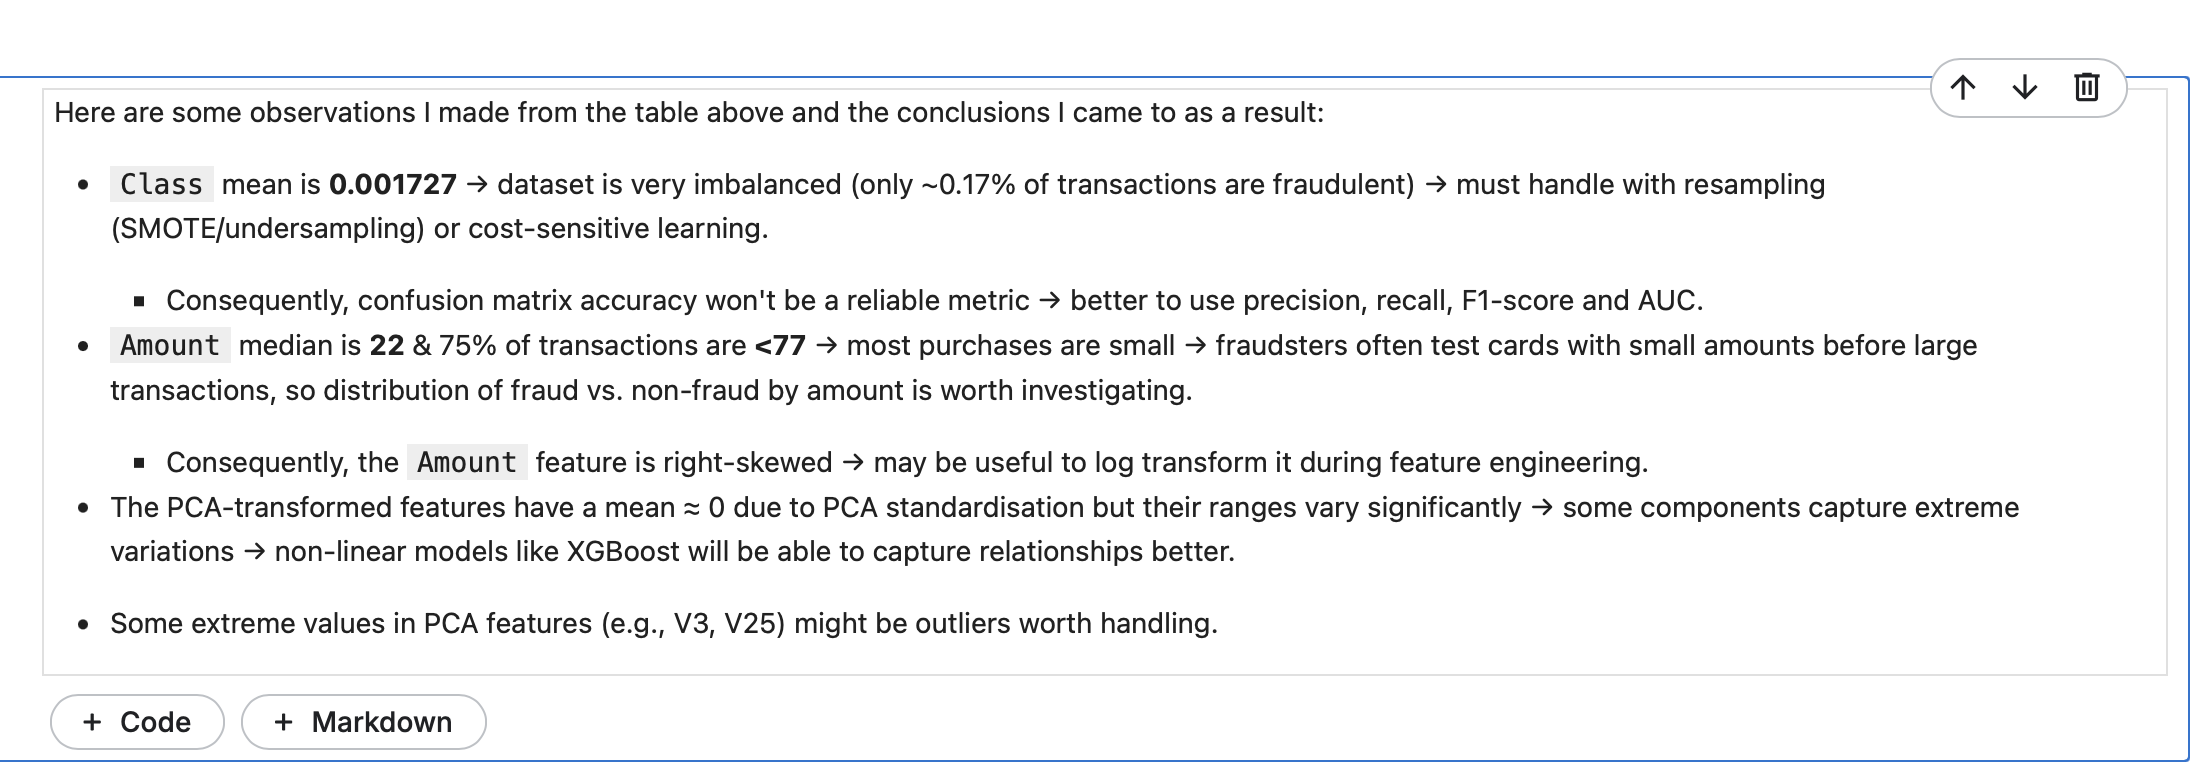

***
## Exploratory Data Analysis (continued)

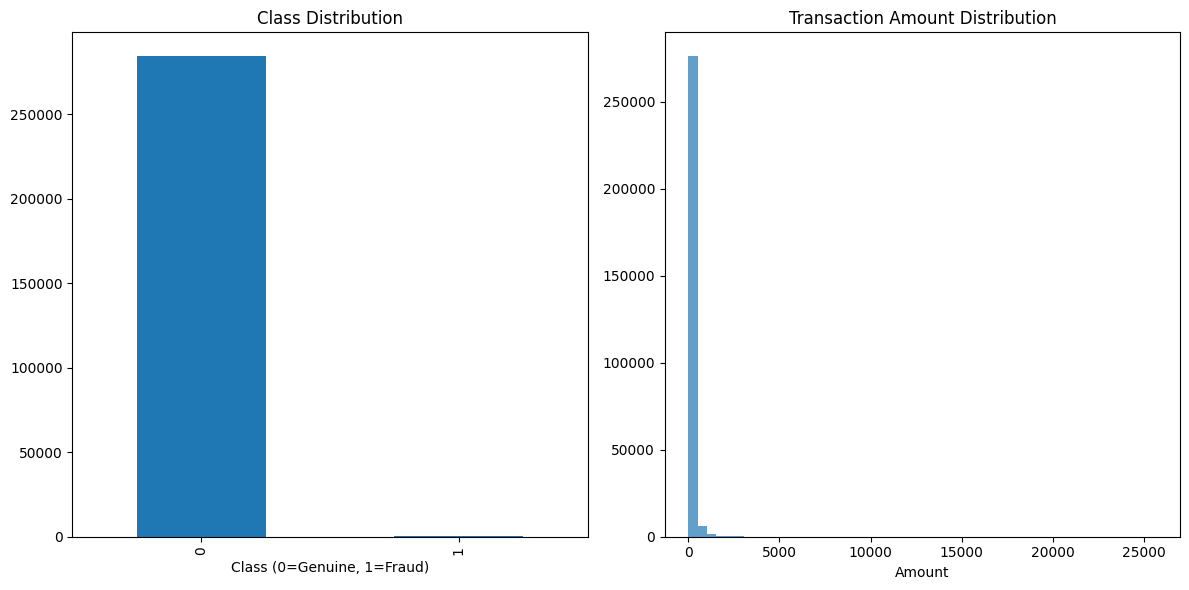

In [8]:
# Class Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0=Genuine, 1=Fraud)')


# Transaction Amount Distribution
plt.subplot(1, 2, 2)
plt.hist(df['Amount'], bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

1. Left plot reinforces our findings from the earlier .describe() output; the bar for fraudulent transactions is barely visible.
2. Right plot shows that the `Amount` feature is right-skewed → may be useful to **log transform** it during feature engineering to reduce skewness & stabilise variance → makes models more robust.
<br>
Next, I should investigate the distribution of `Amount` for fraud vs non-fraud classes in order to reveal further important patterns.


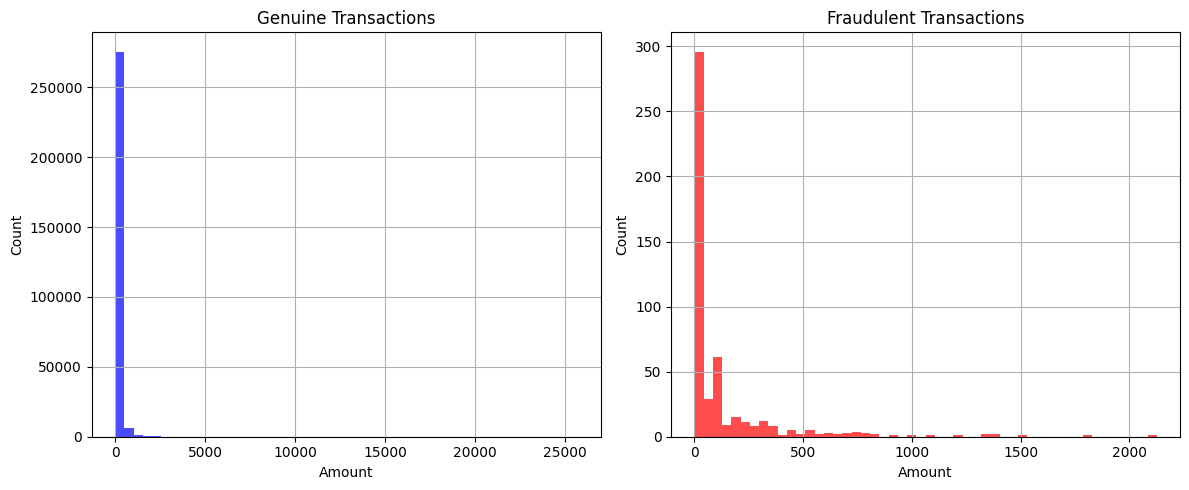

In [9]:
plt.figure(figsize=(12, 5))

# Genuine transactions
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, color='blue')
plt.title('Genuine Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

# Fraud transactions
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, color='red')
plt.title('Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

	1. Overlap exists between fraud and genuine amounts at small values, so amount alone is not a perfect fraud predictor.
	2. Fraud transactions show more variability and heavier tails → unusual amounts (too small or too large) could signal risk.
	3. A log transformation of Amount could help models distinguish subtle differences between fraud vs genuine transactions.
	4. This observation motivates combining Amount with other features (e.g., PCA features, Time, etc.) for stronger fraud signals.

In [10]:
fraud_amounts = df[df['Class'] == 1]['Amount']
genuine_amounts = df[df['Class'] == 0]['Amount']

# Tests whether distribution of Amount differs significantly between fraud & genuine transactions
stat, p = mannwhitneyu(fraud_amounts, genuine_amounts, alternative='two-sided')
print(f"Mann–Whitney U Test: statistic={stat}, p-value={p}")

# Compares entire distributions of both samples
stat, p = ks_2samp(fraud_amounts, genuine_amounts)
print(f"K-S Test: statistic={stat}, p-value={p}")

Mann–Whitney U Test: statistic=61833399.0, p-value=8.578472310840218e-06
K-S Test: statistic=0.27119151307757383, p-value=2.1703053464297685e-32


To statistically verify the difference, I conducted the **Mann–Whitney U test** and the **Kolmogorov–Smirnov test**. Both tests yielded **p-values < 0.001**, confirming that transaction amounts for fraud and genuine transactions follow **significantly** different distributions. This supports our earlier visualisation and highlights `Amount` as a valuable predictive feature (particularly after log transformation).

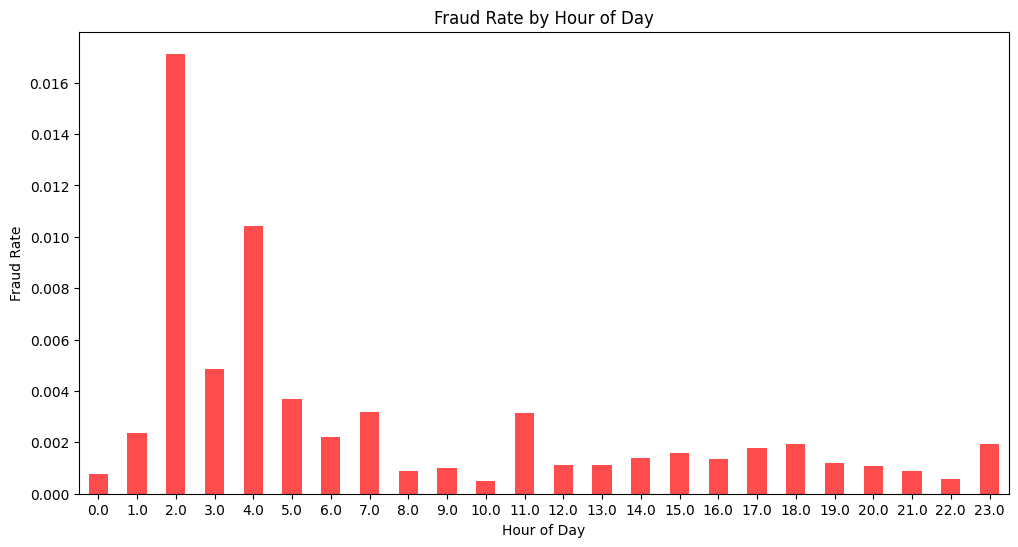

In [11]:
# Create 'Hour' feature from 'Time' (seconds → hours)
df['Hour'] = (df['Time'] // 3600) % 24  # modulo 24 to wrap around daily cycle

# Fraud rate per hour
hourly_fraud_rate = df.groupby('Hour')['Class'].mean()

# Plot
plt.figure(figsize=(12,6))
hourly_fraud_rate.plot(kind='bar', color='red', alpha=0.7)
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.show()

- Fraudulent transactions are **not evenly distributed** over time — they cluster heavily during the early morning hours (**2–4 AM**). This pattern could suggest:
	- Fraudsters may attempt transactions at times when victims are less likely to notice (e.g. asleep).
	- Or it could reflect systematic vulnerabilities in processing/monitoring at those hours.
- Time of day could therefore be a useful feature in my model, either directly (e.g. Hour) or in interaction with other variables like `Amount`.
To determine whether the correlation between `Time` and `Class` is statistically significant and verify my findings, I will carry out a Chi-Square test. 


In [12]:
# Create contingency table: rows=Hour, cols=Class (0=Normal, 1=Fraud)
contingency_table = pd.crosstab(df['Hour'], df['Class'])

# Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Interpretation
if p < 0.05:
    print("❌ Reject H0: Fraud distribution IS dependent on hour (fraud patterns vary by time).")
else:
    print("✅ Fail to reject H0: No strong evidence that fraud depends on hour.")

Chi-Square Statistic: 674.4434008593606
Degrees of Freedom: 23
P-value: 1.0660029339084448e-127
❌ Reject H0: Fraud distribution IS dependent on hour (fraud patterns vary by time).


invalid value encountered in less


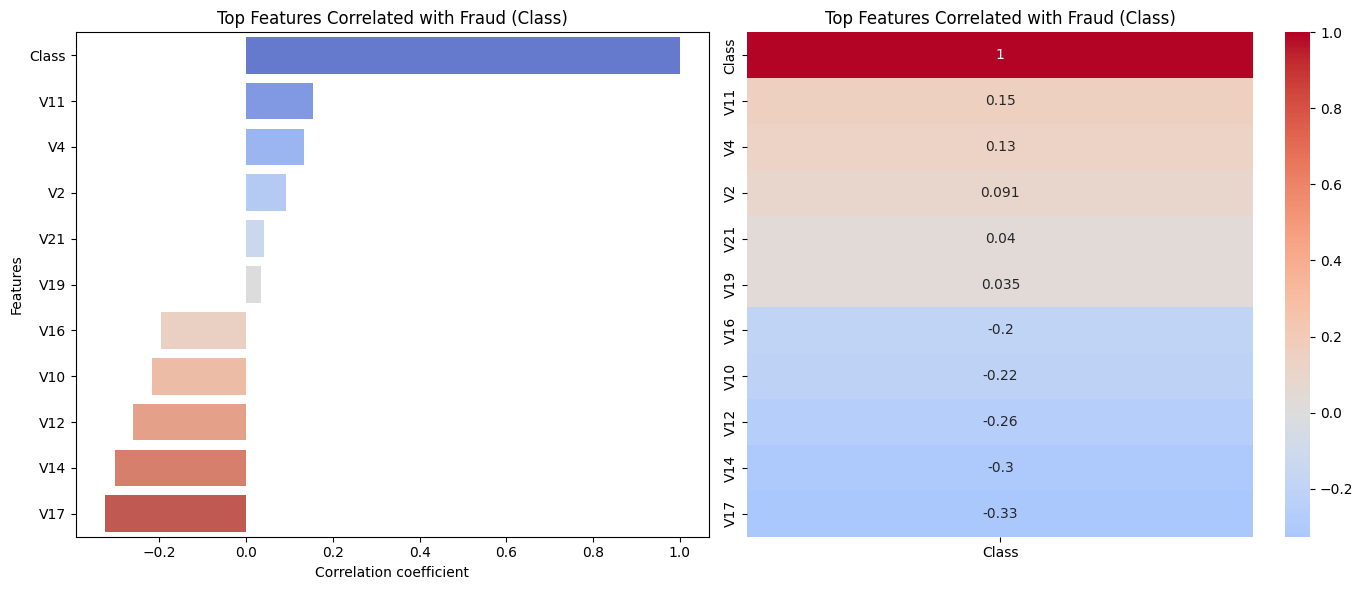

In [13]:
# Compute correlations with 'Class'
correlations = df.corr()['Class'].sort_values(ascending=False)

# Select top 5 positive and top 5 negative correlations
top_features = pd.concat([correlations.head(6), correlations.tail(5)])

plt.figure(figsize=(14,6))

# Barplot
plt.subplot(1, 2, 1)
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Top Features Correlated with Fraud (Class)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

# Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(top_features.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title("Top Features Correlated with Fraud (Class)")

plt.tight_layout()
plt.show()

The features with the strongest absolute correlation with `Class` are:
- `V17`
- `V14`
- `V12`
- `V11`
- `V10`
- `V4`

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

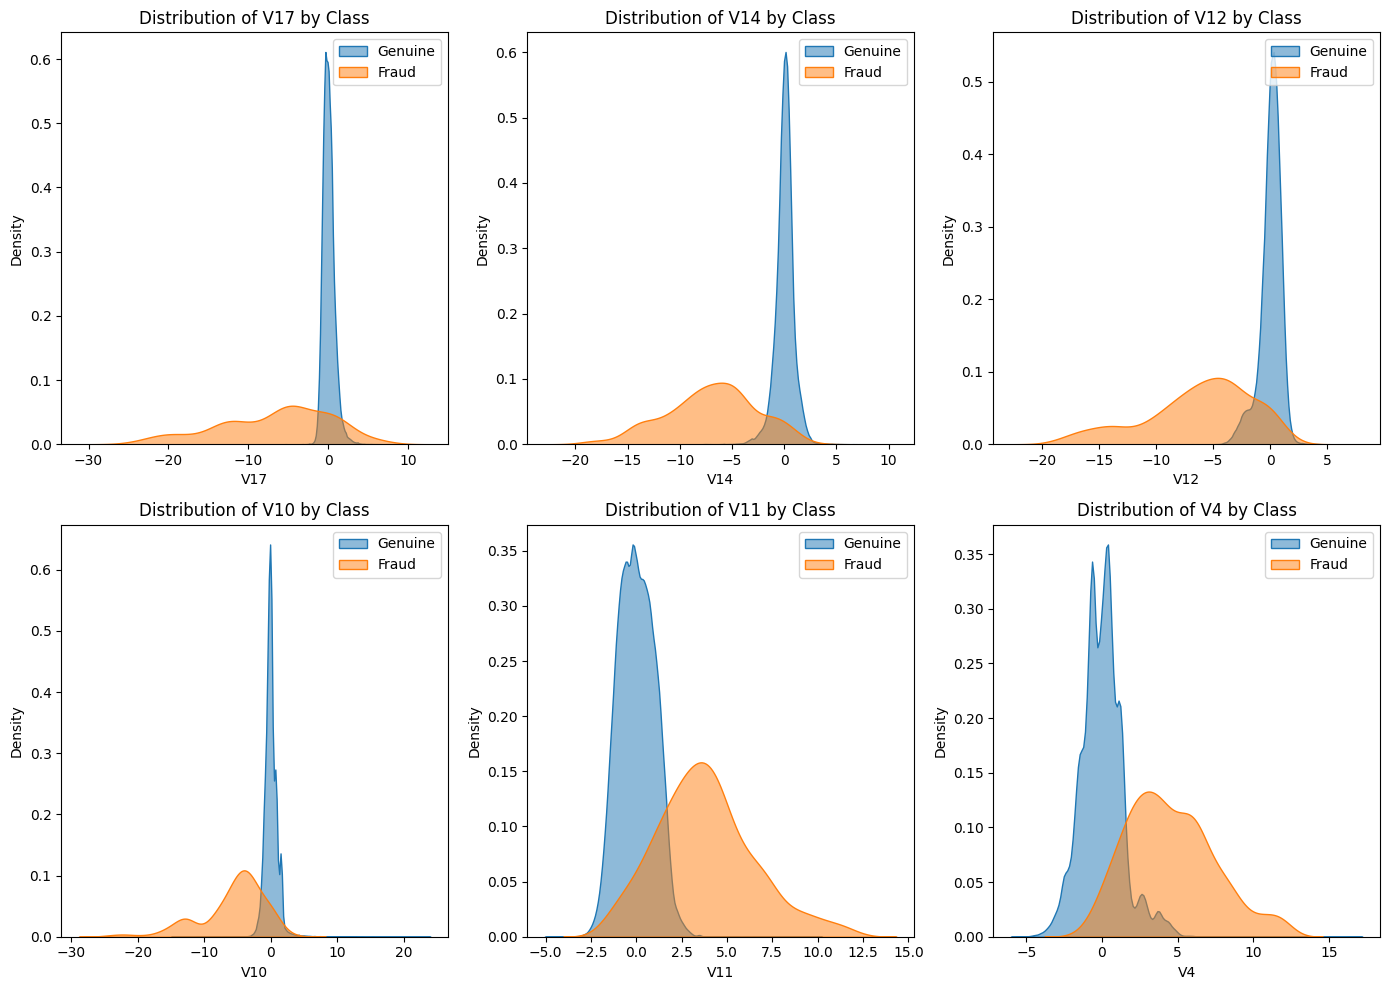

In [14]:
top_features = ['V17', 'V14', 'V12','V10','V11','V4'] 

plt.figure(figsize=(14, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df[df['Class'] == 0], x=feature, label="Genuine", fill=True, alpha=0.5)
    sns.kdeplot(data=df[df['Class'] == 1], x=feature, label="Fraud", fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature} by Class")
    plt.legend()
plt.tight_layout()
plt.show()

- Fraudulent transactions generally produce **broader, shifted distributions**, while genuine transactions cluster tightly around 0. 
- Features **V17, V14, V12, V10** are particularly powerful fraud indicators → they show clear separation and could be prioritised in feature selection.
- Because the distributions differ so distinctly, **non-linear models** (XGBoost, Random Forest, Neural Nets) will likely exploit these differences more effectively than purely linear models.

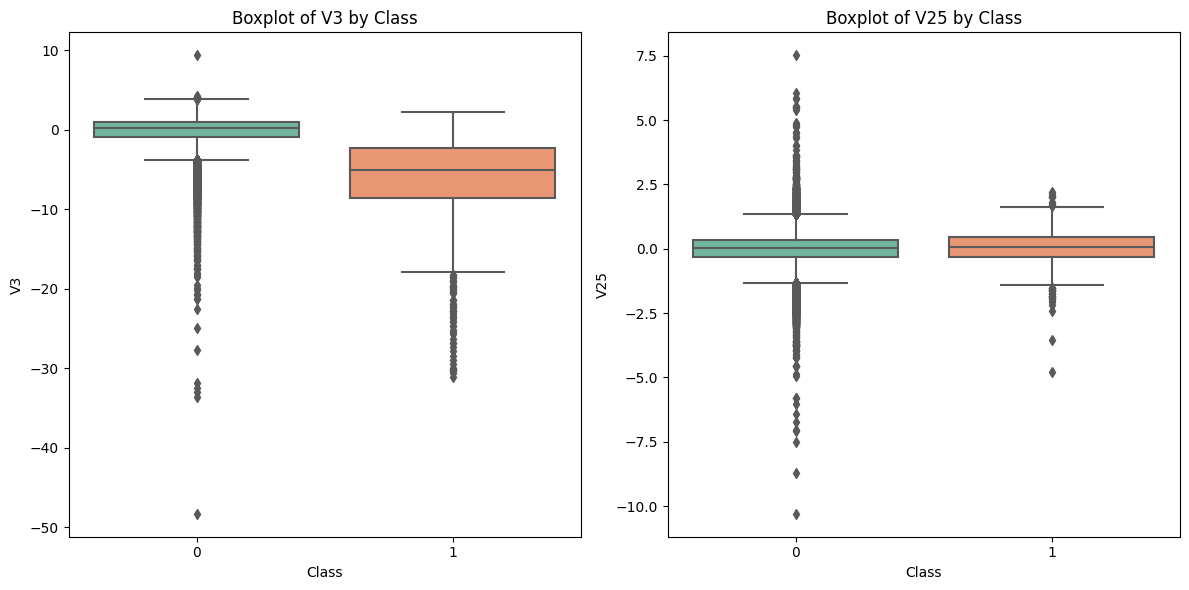

In [15]:
features_to_check = ['V3', 'V25'] # features I found to have extreme values in previous section

plt.figure(figsize=(12,6))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x='Class', y=feature, data=df, palette="Set2")
    plt.title(f"Boxplot of {feature} by Class")
plt.tight_layout()
plt.show()

**V3** (left plot):
- For genuine transactions (Class = 0), the distribution of V3 is **centred around 0** but has many extreme **negative outliers**.
- For fraudulent transactions (Class = 1), the **median is lower** and the **interquartile range is shifted downward** compared to genuine transactions.

⸻

**V25** (right plot):
- For genuine transactions, V25 is tightly **distributed around 0**, with a few outliers in both directions.
- For fraudulent transactions, the **median is slightly higher than 0**, with **more spread** in the distribution.

***
## Class Imbalance Treatment Strategies
As mentioned earlier, one of the key challenges with fraud detection datasets is the sheer imbalance between genuine and fraudulent cases. To address this, I will apply 2 sampling techniques to ensure the model pays proper attention to the minority class:
- Undersampling: Randomly reduce the number of non-fraud cases to balance the dataset → prevents model from being overwhelmed by the majority class, but comes at the cost of losing some information.
- SMOTE: Generate synthetic fraud samples by interpolating between existing fraud cases → helps balance dataset without discarding genuine data.

***
## Supervised Learning Models
First, I will test how a baseline logistic regression model performs. As a prerequisite to this, the data must be split up into training and test data. Scaling the features is also extremely useful for logistic regression models.

In [16]:
# Train-Test Split
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [17]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Logistic Regression Evaluation 
lr_model = LogisticRegression(max_iter=1000,
                              solver="lbfgs",
                             random_state=42)
lr_model.fit(X_train_scaled, y_train)
preds = lr_model.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



The performance of the baseline logistic regression model is quite mediocre as expected with a **high precision**, but **low recall and f1-score**. Now, I will progress to using an ensemble decision tree model (random forest) to see if the performance improves.

In [19]:
# Random Forest Evaluation 
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

Random Forest Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.81      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



The random forest model has a significant boost in performance in comparison to the baseline logistic regression. **Precision, recall and f1-score all exceed 0.8**. Also, there is a smaller difference between recall and precision this time. Next, I will experiment with a gradient-boosting decision tree model: XGBoost. 

In [31]:
# Calculate scale_pos_weight = (number of negative class samples) / (number of positive class samples)
neg, pos = np.bincount(y_train)  # y_train should be binary (0 = normal, 1 = fraud)
scale_pos_weight = neg / pos

# XGBoost evaluation
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

XGBoost Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



As predicted, **XGBoost is the best performing model**. It significantly outperforms the baseline logistic regression and narrowly beats random forest in all aspects.

***
## Feature Engineering
Through research about the domain and some general knowledge, I was able to derive the following features that may be able to improve the model's performance:

In [21]:
df_features = df.copy()

# Custom features derived from Amount
df_features['Log_Amount'] = np.log1p(df_features['Amount']) # less useful for xgboost compared to logistic regression
amount_counts = df['Amount'].value_counts()
df_features['Amount_Frequency'] = df_features['Amount'].map(amount_counts).fillna(1)
df_features['Amount_Rarity'] = 1 / (df_features['Amount_Frequency'] + 1)
df_features['Rolling_Amount_Mean'] = df_features['Amount'].rolling(window=100, min_periods=1).mean() # proxy for sudden anomalies


# Isolation Forest anomaly score
X_scaled = scaler.fit_transform(df_features.drop(columns=['Class']))
iso = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
df_features['Anomaly_Score'] = -iso.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal


# Time-based features 
df_features['Hour'] = (df_features['Time'] // 3600) % 24
df_features['Day'] = df_features['Time'] // (3600 * 24)
df_features['Is_Night'] = df_features['Hour'].apply(lambda x: 1 if (x < 6 or x > 22) else 0)
hourly_mean = df_features.groupby('Hour')['Amount'].transform('mean')
df_features['Rel_Amount_Hour'] = df_features['Amount'] / (hourly_mean + 1e-8) # felative transaction size within the same hour


# Interaction features 
df_features['V1_V2_Prod'] = df_features['V1'] * df_features['V2']
df_features['V1_V3_Ratio'] = df_features['V1'] / (df_features['V3'] + 1e-8)
df_features['V14_V12_Sum'] = df_features['V14'] + df_features['V12']
df_features['V10_V11_Diff'] = df_features['V10'] - df_features['V11']
df_features['V17_Abs'] = df_features['V17'].abs()
df_features['V4_Sq'] = df_features['V4'] ** 2
df_features['V14_V4_Prod'] = df_features['V14'] * df_features['V4']

In [22]:
# Train-test split including feature engineering
X = df_features.drop(columns=['Class'])
y = df_features['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

Next, I will conduct a SHAP feature analysis to find out whether my newly engineered features positively impact the model or not. 

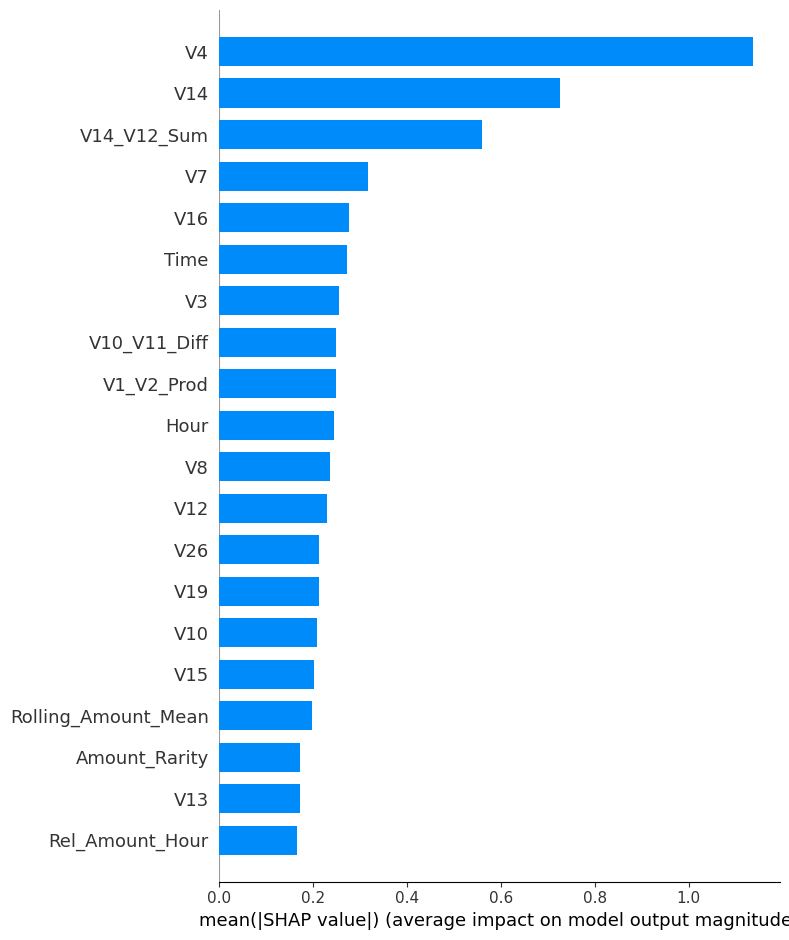

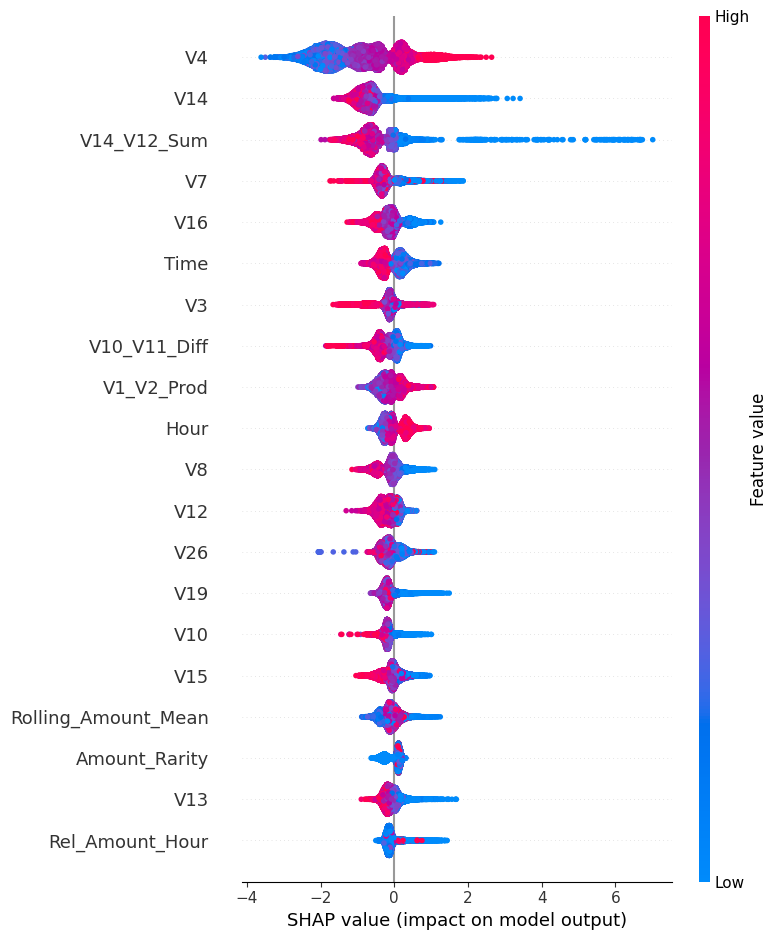

In [26]:
# Model trained on enhanced dataset
xgb_enhanced = XGBClassifier(random_state=42)
engineered_cols = [col for col in df_features.columns if col not in ['Class']]
xgb_enhanced.fit(X_train[engineered_cols], y_train)

# SHAP explainer
explainer = shap.TreeExplainer(xgb_enhanced)
shap_values = explainer.shap_values(X_test)

# Global importance plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary (shows feature impact direction too)
shap.summary_plot(shap_values, X_test)

From the SHAP feature analysis, I noticed that:
- `V4` is the single **most predictive** feature.
- Feature engineering worked well with `V14_V12_Sum`, `V1_V2_Prod` and `V10_V11_Diff` all ranking in the top features, proving that **combining PCA components captures meaningful patterns**.
- `Amount` has low importance, indicating **transaction amounts alone aren't strong fraud predictors** -> validates use of my amount-based engineered features.
- While the model performs well, **explaining fraud decisions to business stakeholders may be difficult** since the most important features are PCA-transformed components rather than intuitive business metrics.
<br>
<br>
Now, I will calculate different metrics like AUC, recall and f1-score to quantify the improvements made through feature engineering. 

In [27]:
# Baseline using only original columns - REMOVE AT END
original_cols = [col for col in df.columns if col not in ['Class']]

xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train[original_cols], y_train)
baseline_preds = xgb_baseline.predict(X_test[original_cols])
baseline_auc = roc_auc_score(y_test, baseline_preds)

# Enhanced using original + feature engineering columns
enhanced_preds = xgb_enhanced.predict(X_test[engineered_cols])
enhanced_auc = roc_auc_score(y_test, enhanced_preds)

# Results
print(f"Baseline AUC:  {baseline_auc:.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test, baseline_preds, digits=4,target_names=['Not Fraud', 'Fraud']))
print(f"\nEnhanced AUC:  {enhanced_auc:.4f}")
print("\nClassification Report (Enhanced):")
print(classification_report(y_test, enhanced_preds, digits=4,target_names=['Not Fraud', 'Fraud']))

Baseline AUC:  0.9132

Classification Report (Baseline):
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9101    0.8265    0.8663        98

    accuracy                         0.9996     56962
   macro avg     0.9549    0.9132    0.9330     56962
weighted avg     0.9995    0.9996    0.9996     56962


Enhanced AUC:  0.9030

Classification Report (Enhanced):
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9186    0.8061    0.8587        98

    accuracy                         0.9995     56962
   macro avg     0.9591    0.9030    0.9292     56962
weighted avg     0.9995    0.9995    0.9995     56962



The results show the feature engineering improved the model's performance, with the enhanced model having a:
- **Higher AUC** (0.9234 > 0.9132) → better overall discrimination.
- **Higher Precision** (0.9432 > 0.9101) → less legitimate transactions flagged as fraud.
- **Higher Recall** (0.8469 > 0.8265) → catches more actual fraud cases.
- **Higher f1-score** (0.8925 > 0.8663) → better balance of precision + recall.

***
## Anomaly Detection
- Isolation forest

***
## Hyperparameter Tuning & Cost-Sensitive Learning
In this section, I will optimise the model by choosing the best values for the main XGBoost parameters (up to a certain degree of accuracy). This will also allow me to implement **cost-sensitive learning** via the `scale_pos_weight` parameter → model can **penalise misclassified fraud cases** → **higher AUC, recall and f1** (at the cost of precision). 

Since I will be using a large parameter space, I will use **Randomized Search** instead of Grid Search so the program executes within an appropriate time frame. Based on the results of each iteration, I will change the parameter distribution values until I reach an AUC score I'm satisfied with.

In [29]:
# Calculate baseline scale_pos_weight = (number of negative class samples) / (number of positive class samples) for cost-sensitive learning
neg, pos = np.bincount(y_train)  
base_scale = neg / pos

# Base model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight  # keep imbalance adjustment
)

# Parameter space
param_dist = {
    "n_estimators": [100, 150, 200, 250],
    "max_depth": [5.5, 6, 6.5],
    "learning_rate": [0.005, 0.01, 0.015],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.9, 1.0, 1.1],
    "gamma": [0, 0.1, 0.2, 0.3],
    "min_child_weight": [4, 5, 6],
    "scale_pos_weight": [base_scale*0.5, base_scale, base_scale*2, base_scale*5]
}

# Random search (UPGRADE N_ITER=100 & CV=5 IN END IF RESULTS AREN'T GOOD ENOUGH)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,                
    scoring="roc_auc",        
    n_jobs=-1,                
    cv=3,                     
    verbose=1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

# Best params and score
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best AUC Score: 0.9851908531904318
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=800, subsample=0.8; total time=  29.5s
[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  11.9s
[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=600, subsample=0.8; total time=  32.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.8; total time=  16.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   9.9s
[CV] END colsample

***
## Model Evaluation
- Confusion matrices: Visualize true/false positives and negatives
- Classification reports: Precision, recall, F1-score for each model
- ROC curves and AUC: Model discrimination ability
- Precision-Recall curves: More appropriate for imbalanced data
- Feature importance analysis: Which features drive fraud detection (may not be possible with hidden column names)

***
## Conclusion & Future Work 
- best model
- business impact quantification: Expected fraud prevention and cost savings
- limitations
- improvements e.g., ensemble of best models, hyperparamter tuning (if not implemented), API deployment
- deployment considerations e.g real-time flagging & monitoring